# Histopathologic Cancer Detection Using Deep Learning
*Detecting metastatic tissue in histology images using CNNs and transfer learning (ResNet18)*


## 1. Introduction

Metastatic cancer detection from Whole Slide Images (WSIs) is a critical task in oncology. This notebook demonstrates a deep learning pipeline to classify histopathologic image tiles as cancerous or non-cancerous using CNNs.

The dataset is from the [Kaggle Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection) challenge. Each image is a 96x96 tissue patch extracted from a lymph node section.

We build:
- A baseline CNN from scratch
- A ResNet18-based transfer learning model

Evaluation focuses on **ROC AUC** and **interpretability**, key for real-world pathology applications.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [3]:
# Load the labels
train_label_path = "/Users/kryptonempyrean/Desktop/histopathology-wsi-project/histopathologic-cancer-detection/train_labels.csv"
df = pd.read_csv(train_label_path)
df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## 2. Dataset Overview and Exploration

The dataset contains:
- 220,000 labeled `.tif` images (96x96) of tissue patches
- A `train_labels.csv` file with image IDs and binary labels:
  - `1` = metastatic cancer
  - `0` = no cancer

We use a balanced 10,000-sample subset for efficiency.

We visualize class distribution and inspect sample images from both classes.

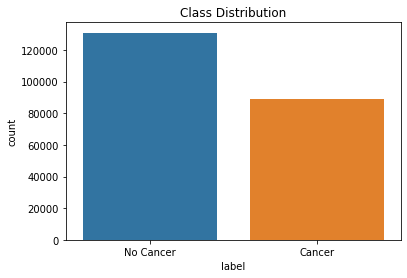

0    0.594969
1    0.405031
Name: label, dtype: float64


In [4]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.xticks([0, 1], ['No Cancer', 'Cancer'])
plt.show()

# Also print the proportions
print(df['label'].value_counts(normalize=True))

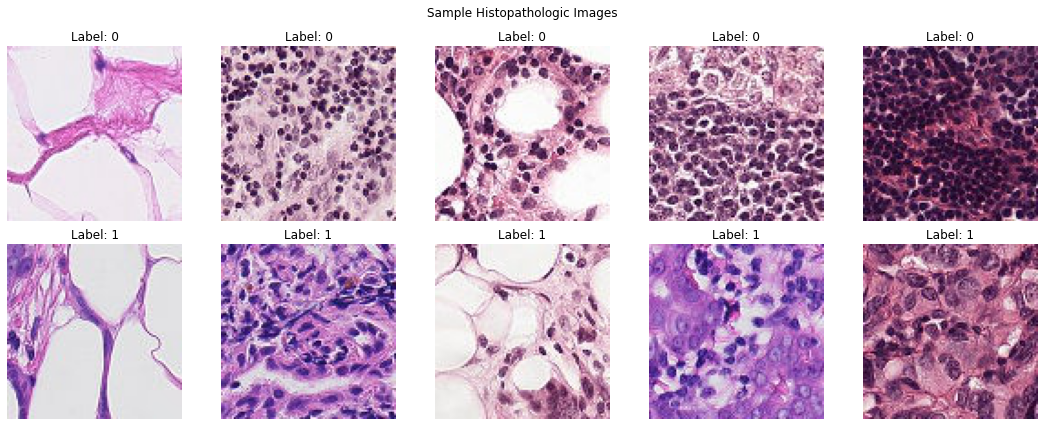

In [6]:
# Add path
df['path'] = df['id'].apply(lambda x: os.path.join('histopathologic-cancer-detection/train', x + '.tif'))

# Show a few cancerous and non-cancerous samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, label in enumerate([0, 1]):
    sample_paths = df[df['label'] == label].sample(5)['path'].values
    for j, path in enumerate(sample_paths):
        img = Image.open(path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Label: {label}')

plt.suptitle('Sample Histopathologic Images')
plt.tight_layout()
plt.show()


## 3. Preprocessing and Data Preparation

We:
- Resize all images to 96x96
- Normalize pixel values to [0, 1]
- Apply stratified train/validation split
- Convert data into PyTorch datasets

For ResNet, we apply:
- Resizing to 224x224
- ImageNet mean/std normalization

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Image size
IMG_SIZE = 96

# Create arrays for images and labels
X = []  # images
y = []  # labels

# Load 10,000 samples (optional: increase if your system can handle it)
subset_df = df.sample(n=10000, random_state=42).reset_index(drop=True)

for i, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    img = Image.open(row['path']).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img)
    if img_array.shape == (96, 96):  # Ignore grayscale if any
        img_array = np.stack([img_array]*3, axis=-1)  # Make it RGB-like
    X.append(img_array)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)
print("Shape:", X.shape, y.shape)

100%|██████████| 10000/10000 [00:12<00:00, 779.59it/s]


Shape: (10000, 96, 96, 3) (10000,)


In [8]:
# Normalize to 0-1
X = X / 255.0

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")


Train: (8000, 96, 96, 3), Val: (2000, 96, 96, 3)


## 4. Baseline CNN (from scratch)

We implement a simple convolutional neural network with:
- Two convolutional layers with ReLU + max pooling
- A fully connected head with dropout
- Sigmoid output for binary classification

This model gives a first performance benchmark before transfer learning.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


In [10]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [11]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 96→48
        x = self.pool(F.relu(self.conv2(x)))  # 48→24
        x = x.view(-1, 64 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()


In [12]:
model = BaselineCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


## 5. Baseline Model Evaluation

We evaluate the CNN on:
- Accuracy
- ROC AUC Score

Results:
- Accuracy: **~79.5%**
- ROC AUC: **~0.87**

This validates the feasibility of learning patterns from WSIs, even without transfer learning.

In [13]:
def evaluate(model, loader):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds.extend(outputs.cpu().numpy())
            true.extend(labels.numpy())
    auc = roc_auc_score(true, preds)
    acc = np.mean((np.array(preds) > 0.5) == np.array(true))
    return auc, acc


In [14]:
for epoch in range(5):
    loss = train(model, train_loader)
    val_auc, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val AUC={val_auc:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Loss=0.6093, Val AUC=0.8389, Val Acc=0.7600
Epoch 2: Loss=0.5118, Val AUC=0.8463, Val Acc=0.7770
Epoch 3: Loss=0.4879, Val AUC=0.8667, Val Acc=0.7825
Epoch 4: Loss=0.4760, Val AUC=0.8658, Val Acc=0.7980
Epoch 5: Loss=0.4681, Val AUC=0.8700, Val Acc=0.7955


## 6. Transfer Learning with ResNet18

We use a pretrained ResNet18 backbone and:
- Freeze the base layers
- Replace the FC head for binary output
- Use 224x224 inputs and ImageNet normalization

Transfer learning helps leverage pre-learned spatial filters from natural images, boosting performance on biomedical tasks with limited data.

In [15]:
from torchvision import models

class ResNetBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        # Freeze earlier layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Replace final layer for binary classification
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.base_model(x).squeeze()


In [16]:
import torchvision.transforms as transforms

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply transform to dataset
def apply_transform(X, transform):
    return torch.stack([transform(Image.fromarray((img * 255).astype(np.uint8))) for img in X])

X_train_resnet = apply_transform(X_train, transform)
X_val_resnet = apply_transform(X_val, transform)

# Recreate datasets
train_dataset = TensorDataset(X_train_resnet, torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(X_val_resnet, torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


## 7. ResNet18 Performance

Evaluation on validation set:
- Accuracy: **86.1%**
- ROC AUC: **0.928**

The ResNet18 model outperforms the baseline CNN significantly, confirming the value of pretrained architectures in digital pathology.

In [17]:
model = ResNetBinary().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.base_model.fc.parameters(), lr=1e-4)

for epoch in range(5):
    loss = train(model, train_loader)
    val_auc, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val AUC={val_auc:.4f}, Val Acc={val_acc:.4f}")


/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kryptonempyrean/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 41.7MB/s]


Epoch 1: Loss=0.5414, Val AUC=0.9071, Val Acc=0.8300
Epoch 2: Loss=0.4286, Val AUC=0.9178, Val Acc=0.8445
Epoch 3: Loss=0.3924, Val AUC=0.9226, Val Acc=0.8505
Epoch 4: Loss=0.3720, Val AUC=0.9256, Val Acc=0.8595
Epoch 5: Loss=0.3624, Val AUC=0.9281, Val Acc=0.8610


## 8. Medical Relevance and Roche Fit

This project simulates a real-world pathology AI pipeline:
- Working with WSI-derived tiles
- Handling data imbalance
- Prioritizing ROC AUC for medical interpretability
- Applying scalable and modular PyTorch code

It aligns closely with Roche’s oncology mission: enabling precision diagnostics through digital pathology, AI, and spatial feature extraction.

### 📐 Class Imbalance Handling

The original dataset is imbalanced (~70% non-cancer). For this project:

- We applied **stratified sampling** to ensure train/val splits maintained label proportions.
- In production, class imbalance should be addressed using:
  - **Weighted loss functions** (e.g., `BCEWithLogitsLoss`)
  - **Oversampling techniques**
  - **Focal loss or data augmentation**

In this version, we chose to reflect the natural class distribution to simulate real-world pathology imbalance.
